In [2]:
# En esta celda se puede probar la funcion de analisis de una imagen

from lib.image import image_data
from lib.analysis import dyssynchrony_analysis
import cv2

# Path completo donde esta la imagen (incluyendo nombre y extencion)
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/240221/'
folder = 'control'
photo_name = 'C1a000'
photo = photo_name + '.tif'
# Ancho de la feta a analisar (es un parametro opcional)
slice_width = 5

# Distancia minima en pixeles entre picos
min_dist_between_maxs = 200
# Calibracion del tiempo de cada pixel
calibration = 1

image = cv2.imread(path + folder + '/'+ photo_name + '.tif')
# Select ROI
fromCenter = False
showCrosshair = False
seleted_parameters = cv2.selectROI(image, fromCenter, showCrosshair)

# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0]) 
y_end = y_start + int(seleted_parameters[2])

cv2.destroyAllWindows()
image = image_data.get_image_data(image)
image = image_data.crop_vertical(image, x_start, x_end)
image = image_data.crop_horizontal(image, y_start, y_end)

results = dyssynchrony_analysis.analyze_image(image, min_dist_between_maxs, calibration, slice_width=slice_width)

/home/leandro/Documentos/Analisis_de_imagenes/CardiAP/DesktopApp/lib/image/image_data.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(


In [15]:
jasonGenerator(path,results,folder,photo_name)

In [19]:
dic = jasonReader(path + folder + '_'+ photo_name + '.json')
slicesParser_peaktime(dic)[0:10]

,transient1,transient2
1,22,21
2,22,21
3,21,22
4,22,21
5,22,22
6,24,22
7,23,22
8,23,22
9,23,23
10,23,23


In [ ]:
print(results['image']['max_peaks_positions'])
for i in range(0,len(results['slices'])):
    array = results['slices'][i]['max_peaks_positions']
    print(i,array)

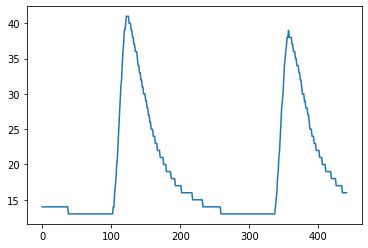

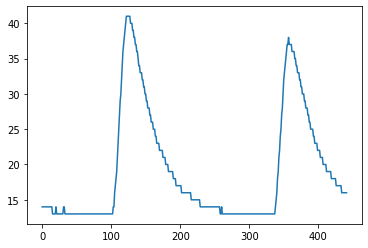

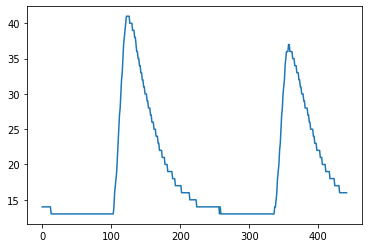

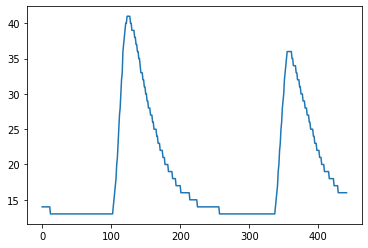

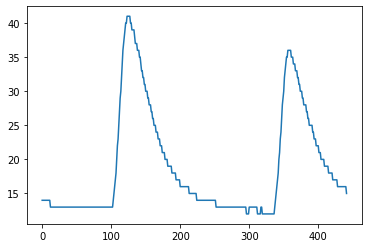

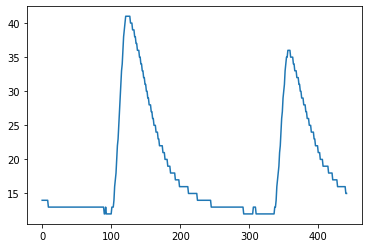

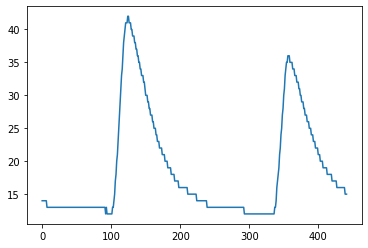

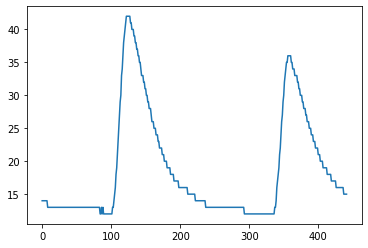

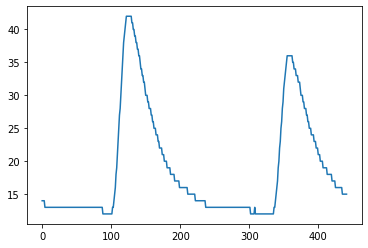

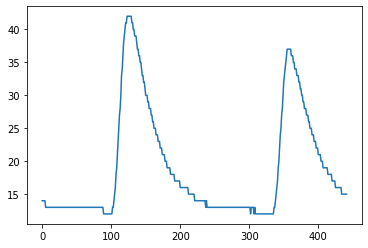

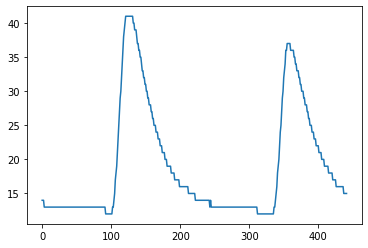

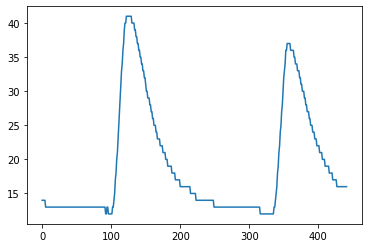

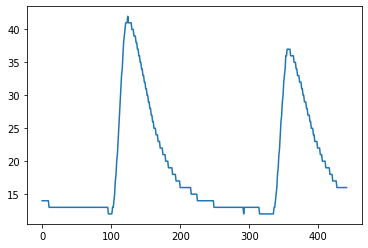

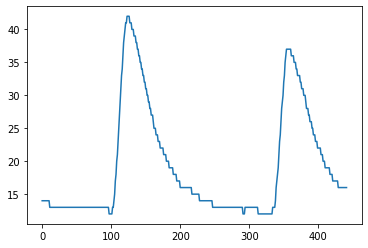

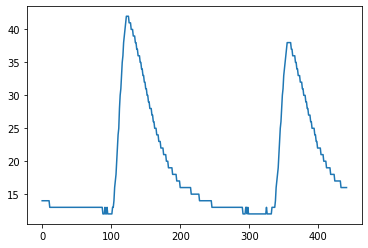

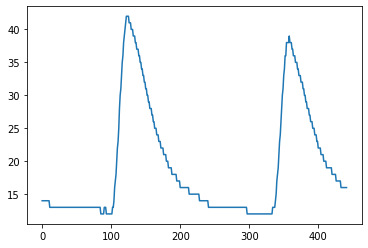

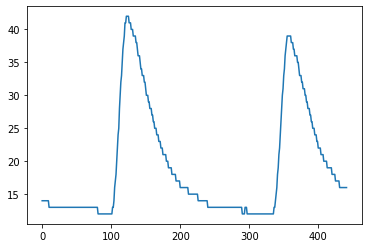

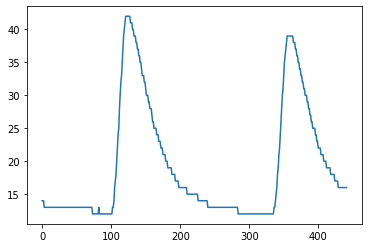

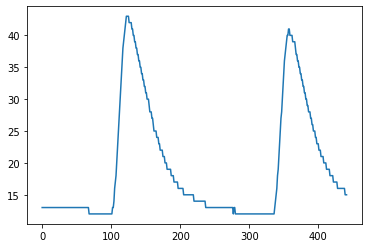

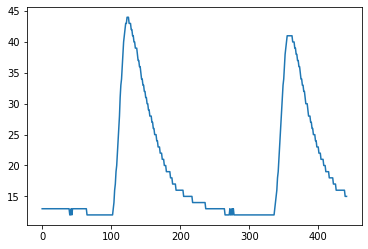

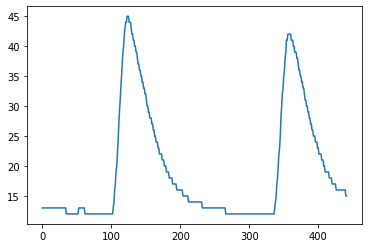

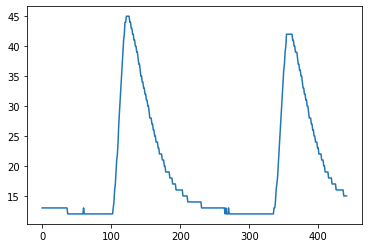

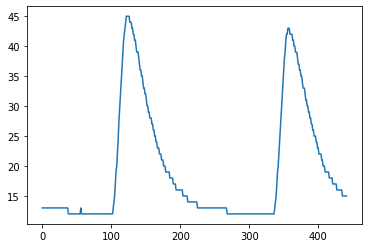

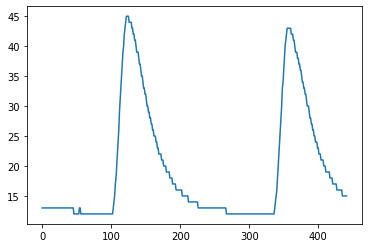

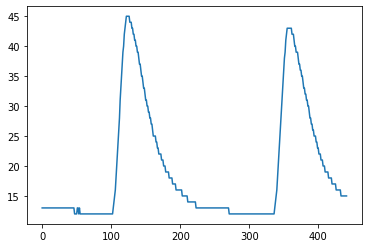

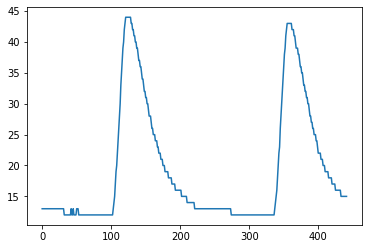

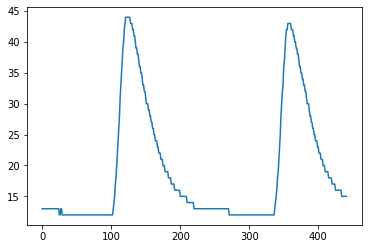

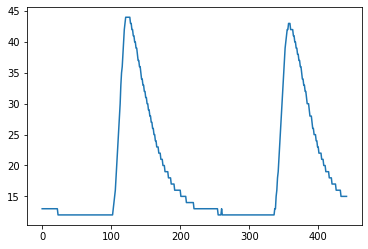

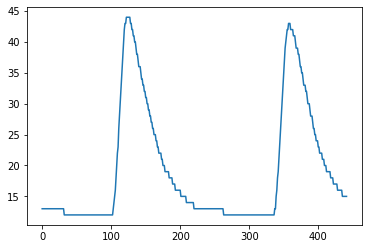

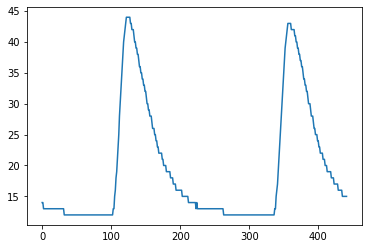

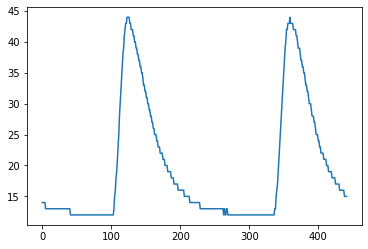

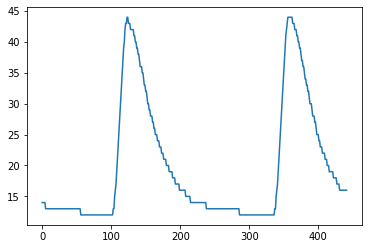

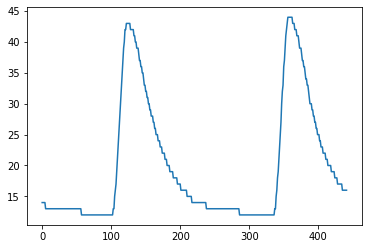

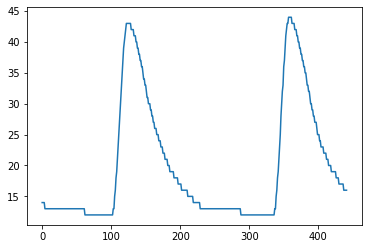

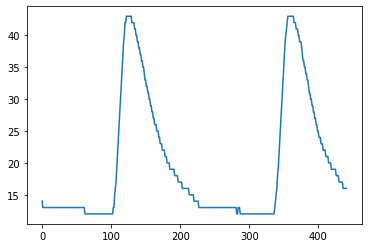

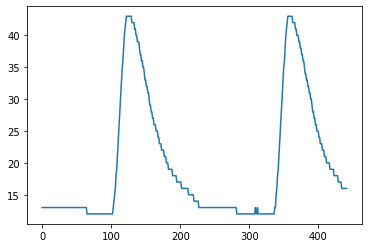

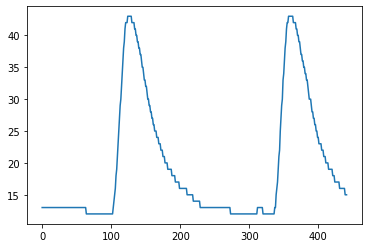

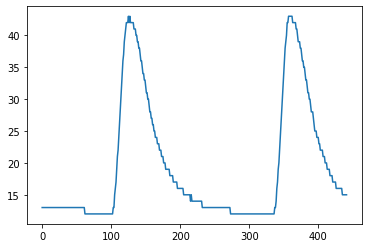

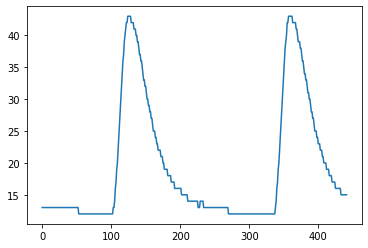

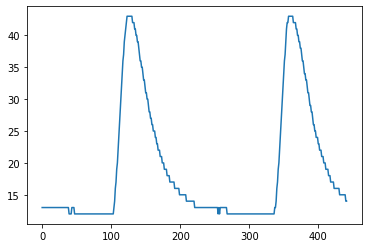

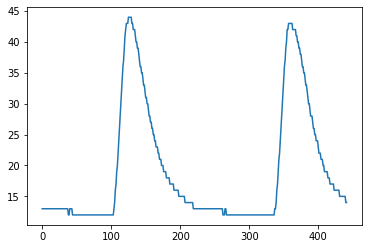

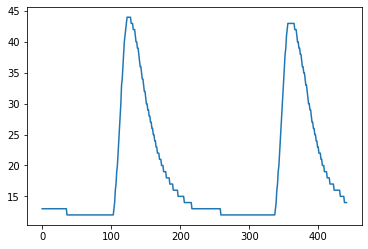

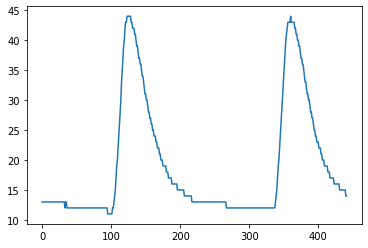

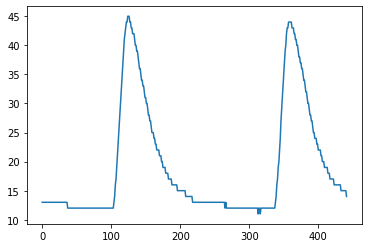

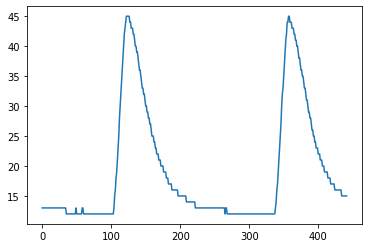

In [18]:
import matplotlib.pyplot as plt

for i in range(0,len(results['slices'])):
    array = results['slices'][i]['intensities']
    plt.plot(array) # plotting by columns
    plt.show()

# PRUEBA ANALISIS 

In [ ]:
# En esta celda se puede probar la funcion de analisis todas las imagenes .tif en un directorio
import os
from lib.image import image_data
from lib.analysis import dyssynchrony_analysis
import cv2

# Ancho de la feta a analisar (es un parametro opcional)
slice_width = 5

# Distancia minima en pixeles entre picos
min_dist_between_maxs = 200

# Calibracion del tiempo de cada pixel
calibration = 3.1

# Path donde estan las imagenes
path = "C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/1 Hz/"

images_paths = [ f'{path}/{file}' for file in os.listdir(path) if file.endswith(".tif") ]
images = [ cv2.imread(image_path) for image_path in images_paths ]

In [ ]:
fromCenter = False
showCrosshair = False

#Tomamos la primer imagen para seleccionar el recorte elegido el resto de las imagenes se van a recortar igual
seleted_parameters = cv2.selectROI(images[0], fromCenter, showCrosshair)

# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0])
y_end = y_start + int(seleted_parameters[2])

cv2.destroyAllWindows()

In [ ]:
images = [ image_data.get_image_data(image) for image in images ]
images = [ image_data.crop_vertical(image, x_start, x_end) for image in images ]
images = [ image_data.crop_horizontal(image, y_start, y_end) for image in images ]

In [ ]:
results = [(dyssynchrony_analysis.analyze_image(image, min_dist_between_maxs, calibration, slice_width=5), print ('Done')) for image in images]

# Analisis de datos
Notas: 
- Image corresponde al análisis de toda la célula y slices corresponde a fetas de esa imagen
- intensidades es el valor que resulta de comprimir (sumando) la matriz con las coordenadas de x,y,z de los pixeles 
- max_peaks_pos es la index de en la lista de intensidades 
- max_peaks_intensities el valor de intensidad que se corresponde con el pico en la posicion analoga de max_peaks_pos

In [3]:
#Imports
import json
import numpy as np
import pandas as pd

In [4]:
#encodes a dictionary into a jason
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def jasonGenerator(path,results,folder, photo_name):
    """ Generates a .jason file in the path given folder from the a dictionary """
    with open(path + folder + '_'+ photo_name +'.json',"w") as miarch:
        miarch.write(json.dumps(results, cls=NumpyEncoder))

In [5]:
def jasonReader(path):
    """ Reads the .jason generated with jasonGenartor the given path"""
    with open(path,'r') as miarch:
        loaded_dict = json.loads(miarch.read())
    return loaded_dict

In [20]:
def wholecellParser(dictres):
    #extract all the slices data
    allSlices = dictres['image']
    #seting columns names
    column_names = ['max_peaks_positions','max_peaks_intensities','min_peaks_positions','min_peaks_intensities','amplitudes','times_to_peaks','tau_s']
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in column_names:
        df_sum.loc[:,i] = allSlices[i][:2]

    return df_sum

In [6]:
def slicesParser_max_peaksI(dictres):
#extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x) for x in range(0,len(allSlices[0]['max_peaks_intensities']))]    
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    for i in range(0,len(allSlices)):
        df_sum.loc[i] = allSlices[i]['max_peaks_intensities'][0:] 
    return df_sum

In [6]:
def slicesParser_max_peaksI(dictres):
#extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x) for x in range(0,len(allSlices[0]['max_peaks_intensities']))]    
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    for i in range(0,len(allSlices)):
        df_sum.loc[i] = allSlices[i]['max_peaks_intensities'][0:] 
    return df_sum

In [7]:
def slicesParser_halfpeakstime(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['times_to_half_peaks']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['times_to_half_peaks']
    return df_sum

In [8]:
def slicesParser_amplitudes(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['amplitudes']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['amplitudes']
    return df_sum

In [9]:
def slicesParser_amplitudes_col(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['amplitudes']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum = pd.concat([df_sum,pd.DataFrame([jasonReader(path_file)['slices'][i]['amplitudes']])], ignore_index=True, axis=0)
    print(df_sum)
    return df_sum

In [10]:
def slicesParser_min_peaksI(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['min_peaks_intensities']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)-1):
        df_sum.loc[i+1] = allSlices[i]['min_peaks_intensities']

    return df_sum

In [11]:
def slicesParser_peaktime(dictres):
    #extract all the slices data
    allSlices = dictres['slices']

    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['times_to_peaks']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['times_to_peaks']

    return df_sum

In [12]:
def slicesParser_tau(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['tau_s']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['tau_s']

    return df_sum

In [13]:
def BasicStasts(df):
    if df.empty == False:
        return df.astype('int').describe()

In [14]:
def amplitudes_ratio(df):
    df_alt = pd.DataFrame()
    for i in range(0,len(list(df))-1):
        name = 'ratio' + str(i+1) +'-' + str(i)
        df_alt[name] = df[list(df)[i+1]]/df[list(df)[i]]
    return df_alt

In [ ]:
# path = '/home/leandro/Documentos/Analisis_de_imagenes/CardiAP/DesktopApp/photos_examples/'
photo_name = 'c1d000'
photo = photo_name + '.tif'

In [ ]:
loaded_dict = jasonReader(path)

In [ ]:
BasicStasts(slicesParser_max_peaksI(path))

In [ ]:
amplitudes_ratio(slicesParser_amplitudes(path)).std()

In [ ]:
amp_mean = slicesParser_amplitudes(path).mean()
for i in range(0,len(amp_mean)-1):
    AR_ind = (1- (amp_mean[i+1])/amp_mean[i])
    print (AR_ind)

In [ ]:
slicesParser_min_peaksI(path).head(2)

In [ ]:
slicesParser_tau(path).head()

In [100]:
def discordance_index(path):
    DIs = pd.DataFrame()
    for j in range (1, len(slicesParser_amplitudes(path).columns)):
        rel_diff = []
        for i in range (0, len (slicesParser_amplitudes(path))):
            T1 = list(slicesParser_amplitudes(path)['transient'+str(j)])[i]
            T2 = list(slicesParser_amplitudes(path)['transient'+str(j+1)])[i]
            rel_diff.append((T1-T2)/max(T1,T2))
        DIs[j] = rel_diff
    return DIs
def alternance_ratio(path):
    T1_mean = float(slicesParser_amplitudes(path)['transient1'].mean())
    T2_mean = float(slicesParser_amplitudes(path)['transient2'].mean())
    AR = (abs(T1_mean-T2_mean))/max(T1_mean, T2_mean)
    return AR

In [101]:
import os

DI_list = []
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/imagenes/37°/'
jsons_list = os.listdir(path)
file_error = []
for file in jsons_list:
    try:
        path_file = path + file
        dic = jasonReader(path_file)
        print (file)
        DI_list.append([file, discordance_index(dic).std().mean()])
    except ValueError:
        file_error.append(file)
    except IsADirectoryError:
        pass
    except FileNotFoundError:
        pass
    except ZeroDivisionError:
        file_error.append(file)
print('Done')

37°040412_c4b003.json
37°180712_1e001.json
37°030412_c3b000.json
37°180712_2b001.json
37°030412_c2b000.json
37°270312_270312g0.json
37°200712_3c001.json
37°160712_6b000.json
37°160712_3b000.json
37°030412_c1e000.json
37°160712_5b000.json
37°040412_c3b000.json
37°040412_c2b000.json
37°030412_c5b000.json
37°030412_c6b000.json
37°030412_c4b000.json
Done


In [102]:
file = []
for index in range(0,len(DI_list)):
    file.append([jsons_list[index], np.array(DI_list[index]).std().mean()])

TypeError: cannot perform reduce with flexible type

In [106]:
import csv
import pandas as pd    

df = pd.DataFrame(DI_list, columns= ['photo_name','DI'])
df.to_csv(path + 'discordances_indexes_37.csv', sep='\t', decimal=',')

In [ ]:
with open(path + 'Failed.txt', 'w') as file:
    for item in file_error:
        file.write("%s\n" % item)

In [ ]:
import os

AR_list = []
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/'
jsons_list = os.listdir(path)
for file in jsons_list:
    try:
        path_file = path + file
        dic = jasonReader(path_file)
        T1_mean = dic['image']['amplitudes'][0]
        T2_mean = dic['image']['amplitudes'][1]
        AR_list.append([file, (abs(T1_mean-T2_mean))/max(T1_mean, T2_mean)])
    except IsADirectoryError:
        pass
print('Done')

In [105]:
import csv
import pandas as pd    

df = pd.DataFrame(AR_list, columns= ['photo_name','AR'])
df.to_csv(path + 'alternance_ratio_nuevos.csv', sep='\t',decimal=',')

NameError: name 'AR_list' is not defined

In [117]:
import pandas as pd  

disc_index = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/discordances_indexes.csv', encoding='utf-8', sep=',')
del disc_index['Unnamed: 0']

In [ ]:
[x for x in disc_index['photo_name'] if '31019' in x ]

In [118]:
tab = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/tabulado_imagenes.csv', encoding='utf-8')
del tab['Unnamed: 0']
pd.set_option('display.max_rows', None)
tab.head()

,experimento,carpeta,foto,tratamiento,frecuencia,dosis
0,31019,031019c2,c2c000,vk,3,5
1,31019,031019c2,c2d000,vk,4,5
2,31019,031019c2,c2e000,vk,5,5
3,31019,031019c2,c2b000,vk,1,5
4,31019,031019c3,c3c000,d,3,5


In [119]:
for j in range(0,len(disc_index)):
    for i in range(0,len(tab)):
        if str(tab['experimento'][i]) in disc_index['photo_name'][j]:
            if str(tab['foto'][i]) in disc_index['photo_name'][j]:
                tab.loc[i,'DI'] = disc_index['DI'][j]

In [123]:
tab_c5 = tab[(tab['tratamiento']=='c') & (tab['frecuencia']==5)]

In [ ]:
tab.to_excel('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/jsons/tab_prueba2.xlsx',engine='xlsxwriter')

In [ ]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
c_1 = tab[(tab['tratamiento'] == 'c') & (tab['frecuencia'] == 1) & (tab['dosis'] == 0)]
del c_1['tratamiento']
del c_1['frecuencia']
c_3 = tab[(tab['tratamiento'] == 'd') & (tab['frecuencia'] == 1) & (tab['dosis'] == 5)]
del c_3['tratamiento']
del c_3['frecuencia']
c_4 = tab[(tab['tratamiento'] == 'vk') & (tab['frecuencia'] == 1) & (tab['dosis'] == 5)]
del c_4['tratamiento']
del c_4['frecuencia']
# c_5 = tab[(tab['tratamiento'] == 'c') & (tab['frecuencia'] == 5)]
# del c_5['tratamiento']
# del c_5['frecuencia']


df1 = pd.concat([c_1.reset_index(),c_3.reset_index(),c_4.reset_index()],axis =1, ignore_index=True, sort=False)
df1.head()
df1.to_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/DI_nuevos.csv', encoding='utf-8', sep='\t')

In [ ]:
DI = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/DI_nuevos.csv', encoding='utf-8', sep=',')


import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import SubplotZero
fig = plt.figure()
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)


for direction in ["right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
    
for row in range(0,len(DI)):
    plt.plot(DI.loc[row],'o''-')
    plt.box(on=None)
plt.show()

In [ ]:
c_1 = disc_index[(disc_index['tratamiento'] == 'c') & (disc_index['frecuencia'] == 1)]['DI']
c_3 = disc_index[(disc_index['tratamiento'] == 'c') & (disc_index['frecuencia'] == 3)]['DI']
c_4 = disc_index[(disc_index['tratamiento'] == 'c') & (disc_index['frecuencia'] == 4)]['DI']
c_5 = disc_index[(disc_index['tratamiento'] == 'c') & (disc_index['frecuencia'] == 5)]['DI']


df = pd.concat([c_1.reset_index()['DI'],c_3.reset_index()['DI'],c_4.reset_index()['DI'],c_5.reset_index()['DI']],axis =1, ignore_index=True, sort=False)

In [125]:
from scipy.stats import ttest_ind, ttest_ind_from_stats

# DI = DI.interpolate(method ='linear', limit_direction ='forward')
t, p = ttest_ind(tab_c5['DI'].dropna(), df['DI'].dropna(), equal_var=False)
p

0.10139653713145837

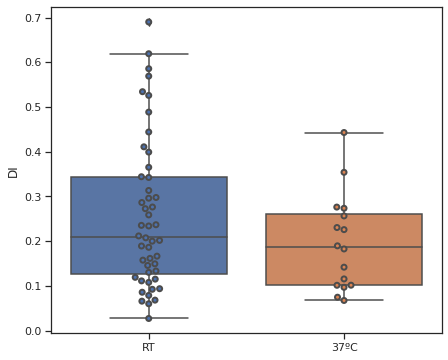

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))


sns.boxplot(data=(tab_c5['DI'].dropna(), df['DI'].dropna()))

sns.swarmplot(data=(tab_c5['DI'].dropna(), df['DI'].dropna()), linewidth=2)
plt.xticks ([0,1],['RT','37ºC'])
plt.ylabel('DI')
plt.savefig(path + 'DI_temperatura')

In [ ]:
plt.scatter()